In [2]:
# url for train data: https://transfer.sh/RyD0RfrNuu/mnist_train.csv -P data/
# url for test data: https://transfer.sh/NC2NJipGvn/mnist_test.csv -P data/
# Using transfer.sh to host the data

import os
import urllib.request
import pandas as pd

filepath_train = 'data/mnist_train.csv'
url_train = 'https://transfer.sh/RyD0RfrNuu/mnist_train.csv'
filepath_test = 'data/mnist_test.csv'
url_test = 'https://transfer.sh/NC2NJipGvn/mnist_test.csv'

if not os.path.exists(filepath_train):
  urllib.request.urlretrieve(url_train, filepath_train)

if not os.path.exists(filepath_test):
  urllib.request.urlretrieve(url_test, filepath_test)


data = pd.read_csv('data/mnist_train.csv')
# data = pd.read_csv(url)
data.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Idea

Create 10 model, model i answer whether the picture is of the i-th digit

In [3]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

class LossFunction:

    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def loss(self, a : np.ndarray): # a is the coefficient vector
        prob = sigmoid(np.dot(self.X, a))
        values = - self.y * np.log(prob) - (1 - self.y) * np.log(1 - prob)
        return np.nansum(values) / self.y.shape[0]
        # Vi han che gia tri ham loss function nen can chia trung binh
        # de tranh bi tran so giong normalize data

    def gradient(self, a : np.ndarray):
        prob = sigmoid(np.dot(self.X, a)) # aT * X or XT * a = tich vo huong
        sub_coefficient = -(self.y - prob) 
        return np.dot(self.X.T, sub_coefficient) / self.y.shape[0]
    
    def precision(self, a : np.ndarray):
        prob = sigmoid(np.dot(self.X, a))
        prob = np.array(prob >= 0.5, dtype=np.int32)
        return np.sum(prob == self.y) / self.y.shape[0]

### Data


In [4]:
X = data.drop('label', axis=1).values # Data ko chua label
# X shape m * 784
# Axis = 1 mean drop column
# Axis = 0 mean drop row

#append a column of 1s for ax + by + c (x, y, 1) and (a, b, c)
X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
y = data['label'].values
X.shape, y.shape

((60000, 785), (60000,))

In [5]:
# Test code cell
y

array([5, 0, 4, ..., 5, 6, 8])

In [6]:
loss_functions = []
for digit in range(10):
    y_digit = np.array(y == digit, dtype=np.int32) # y_digit is a vector of 0 and 1
    loss_functions.append(LossFunction(X, y_digit))

In [7]:
loss_functions

### Train data

In [8]:
def gradient_descent(loss_func, starting_point, learning_rate = 0.00001, num_steps = 40, precision=0.00001):
    cur_point = starting_point
    for i in range(num_steps):
        grad = loss_func.gradient(cur_point)
        # print("Iteration {}: loss = {}, precision = {}".format(i, loss_func.loss(cur_point), loss_func.precision(cur_point)))
        cur_point = cur_point - learning_rate * grad
        if np.linalg.norm(grad) < precision:
            break
    return cur_point

In [9]:
optimal_points = []

for digit in range(10):
    optimal_point = gradient_descent(loss_functions[digit], np.zeros(X.shape[1]))
    print("Accuracy for digit {}: {}".format(digit, loss_functions[digit].precision(optimal_point)))
    optimal_points.append(optimal_point)

Accuracy for digit 0: 0.9843333333333333
Accuracy for digit 1: 0.98625
Accuracy for digit 2: 0.9673333333333334
Accuracy for digit 3: 0.96225
Accuracy for digit 4: 0.9729333333333333
Accuracy for digit 5: 0.9528166666666666
Accuracy for digit 6: 0.9795666666666667
Accuracy for digit 7: 0.9779166666666667
Accuracy for digit 8: 0.9358166666666666
Accuracy for digit 9: 0.9471333333333334


In [10]:
def evaluate(X, y, optimal_points):
    y_pred = infer(X, optimal_points)
    return np.sum(y_pred == y) / y.shape[0]
evaluate(X_test, y_test, optimal_points)

NameError: name 'X_test' is not defined

### Inference

In [11]:
def infer(X, optimal_points):
    prob = np.zeros((X.shape[0], 10))
    for digit in range(10):
        prob[:, digit] = sigmoid(np.dot(X, optimal_points[digit]))
    # print(prob.shape)
    return np.argmax(prob, axis=1) # return index of max value in each column

In [12]:
prob = infer(X, optimal_points)

In [13]:
prob

array([3, 0, 4, ..., 5, 6, 8])

In [14]:
import matplotlib.pyplot as plt

def draw_digit(data, row_id):
    row = data.iloc[row_id]
    label = row['label']
    image = row.drop('label').values.reshape(28, 28)
    plt.title('Digit Label = {}'.format(label))
    plt.imshow(image, cmap='gray')
    plt.show()

In [15]:
data_test = pd.read_csv('data/mnist_test.csv')
X_test = data_test.drop('label', axis=1).values
X_test = np.concatenate((X_test, np.ones((X_test.shape[0], 1))), axis=1)
y_test = data_test['label'].values


In [16]:
idx_test = 5999

[7]


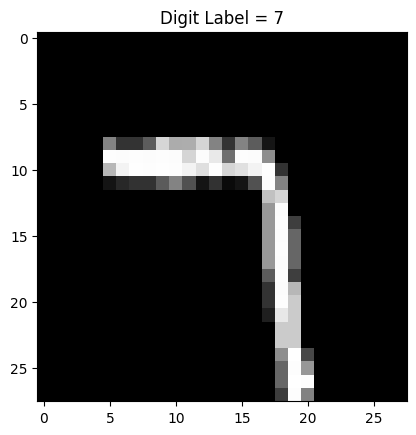

In [17]:
print(infer(np.array([X_test[idx_test]]), optimal_points))
draw_digit(data_test, idx_test)

### Softmax values

In [18]:
#Write softmax function
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

In [19]:
# Execute softmax function for X_test
prob_softmax = np.array(softmax(np.dot(X_test[idx_test], np.array(
    optimal_points).T)), dtype=float)  # T is transpose
prob_softmax

array([3.15725929e-03, 3.98794048e-04, 3.02123377e-03, 6.96229101e-03,
       4.54614533e-03, 1.83255720e-02, 2.82382550e-03, 9.33751398e-01,
       5.05966692e-03, 2.19538145e-02])

In [20]:
# Calculate sum of prob_softmax - Check if it is equal to 1
sum_prob_softmax = np.sum(prob_softmax)
sum_prob_softmax

1.0

In [21]:
def softmax(z):
    # Implement the stable version of softmax
    return np.exp(z - np.max(z, axis=1, keepdims=True)) / np.sum(np.exp(z - np.max(z, axis=1, keepdims=True)), axis=1, keepdims=True)

class LossFunction:
    def __init__(self, X, y):
        self.X = X
        self.y = np.zeros((y.shape[0], 10))
        self.y[np.arange(y.shape[0]), y] = 1
        print(self.X.shape, self.y.shape)

    def loss(self, W : np.ndarray):
        # Calculate the loss function
        # W: shape 785 x 10
        prob = softmax(np.dot(self.X, W))
        #avoid inf
        prob = np.clip(prob, 1e-15, 1 - 1e-15)
        values = - np.nansum(self.y * np.log(prob))
        return values / self.X.shape[0]
    
    def gradient(self, W : np.ndarray):
        # Calculate the gradient
        prob = softmax(np.dot(self.X, W))
        difference = -(self.y - prob) 
        return np.dot(self.X.T, difference) / self.X.shape[0]
    
    def precision(self, W : np.ndarray):
        prob = softmax(np.dot(self.X, W))
        prob = np.argmax(prob, axis=1)
        return np.sum(prob == y) / y.shape[0]
loss_func = LossFunction(X, y)
# Randomly initialize W, each has real value from normal distribution between -0.01 and 0.01
W = np.random.normal(0, 0.01, (X.shape[1], 10))
loss_func.loss(W)

(60000, 785) (60000, 10)


25.096274643901403

In [22]:
# Gradient descent with line search Wolfe Condition to find the suitable learning rate
def gradient_descent(loss_func, starting_point, num_steps = 40, precision=0.00001):
    cur_point = starting_point
    for i in range(num_steps):
        initial_learning_rate = 0.001
        grad = loss_func.gradient(cur_point)
        while (True):
            # Check the Wolfe condition
            if (loss_func.loss(cur_point - initial_learning_rate * grad) <= loss_func.loss(cur_point) - 0.0001 * initial_learning_rate * np.sum(grad ** 2)):
                break
            initial_learning_rate = initial_learning_rate * 0.8
        cur_point = cur_point - initial_learning_rate * grad
        print("Iteration {}: loss = {}, precision = {}".format(i, loss_func.loss(cur_point), loss_func.precision(cur_point)))
    return cur_point


In [24]:
# Adam optimizer
def adam(loss_func, starting_point, num_steps = 40, precision=0.00001):
    cur_point = starting_point
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8
    m = np.zeros(cur_point.shape)
    v = np.zeros(cur_point.shape)
    for i in range(num_steps):
        grad = loss_func.gradient(cur_point)
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        m_hat = m / (1 - beta1 ** (i + 1))
        v_hat = v / (1 - beta2 ** (i + 1))
        cur_point = cur_point - 0.006 * m_hat / (np.sqrt(v_hat) + epsilon)
        print("Iteration {}: loss = {}, precision = {}".format(i, loss_func.loss(cur_point), loss_func.precision(cur_point)))
    return cur_point

In [25]:
W = gradient_descent(loss_func, W, num_steps=100, precision=0.00001)

Iteration 0: loss = 19.143245416851375, precision = 0.40641666666666665
Iteration 1: loss = 18.95141746106452, precision = 0.4258166666666667
Iteration 2: loss = 18.193093431322154, precision = 0.4371833333333333
Iteration 3: loss = 17.982520897357954, precision = 0.4542
Iteration 4: loss = 17.950176810570913, precision = 0.41981666666666667
Iteration 5: loss = 14.43964654021054, precision = 0.5506833333333333
Iteration 6: loss = 12.75789435666089, precision = 0.5841
Iteration 7: loss = 11.383717584957864, precision = 0.63075
Iteration 8: loss = 10.320786482906561, precision = 0.6488666666666667
Iteration 9: loss = 10.164063305122898, precision = 0.65015
Iteration 10: loss = 10.04669428240463, precision = 0.6635833333333333
Iteration 11: loss = 8.403510573508607, precision = 0.7099666666666666
Iteration 12: loss = 7.2157912038522625, precision = 0.7396166666666667
Iteration 13: loss = 6.860263145736326, precision = 0.76525
Iteration 14: loss = 5.1218763234519935, precision = 0.80483333

In [26]:
W = adam(loss_func, W, num_steps=200, precision=0.00001)

Iteration 0: loss = 22.158634900785824, precision = 0.33516666666666667
Iteration 1: loss = 28.08851054679652, precision = 0.12391666666666666
Iteration 2: loss = 20.28845768052143, precision = 0.31621666666666665
Iteration 3: loss = 20.643962539152135, precision = 0.32493333333333335
Iteration 4: loss = 19.258954756194193, precision = 0.3771833333333333
Iteration 5: loss = 16.196410623763914, precision = 0.47551666666666664
Iteration 6: loss = 13.510960152888686, precision = 0.5781
Iteration 7: loss = 12.370933541004494, precision = 0.6069
Iteration 8: loss = 10.549921999468873, precision = 0.6548166666666667
Iteration 9: loss = 11.1391260787693, precision = 0.63635
Iteration 10: loss = 11.69552216478553, precision = 0.6157
Iteration 11: loss = 9.354955699178925, precision = 0.6752833333333333
Iteration 12: loss = 6.679518881544701, precision = 0.7530666666666667
Iteration 13: loss = 7.602369121950875, precision = 0.7243166666666667
Iteration 14: loss = 8.627734862000429, precision = 